## Import all the libraries

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import io
import glob
import zipfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

%config InlineBackend.figure_format = 'retina'
import random
import numpy as np
import pandas as pd
import tensorflow as tf, re, math
import efficientnet.tfkeras as efn
import tensorflow.keras.backend as K
from tensorflow import keras
import sklearn
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score,
                             confusion_matrix
                            )
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from plotly.offline import (init_notebook_mode,
                            iplot,
                            plot
                           )
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns

import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio

import warnings
warnings.filterwarnings("ignore")

In [7]:
!pip install efficientnet

## Notebook Configuration

In [ ]:

DEVICE = "TPU" 
BATCH_SIZE = 16 * 8
SEED = 29
IMG_SIZES = [[255, 255]]
EPOCHS = [12]
AUGMENT   = True
TRANSFORM = True

ROT_    = 0.0
SHR_    = 2.0
HZOOM_  = 8.0
WZOOM_  = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [ ]:
def seed_it(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('Notebook has been seeded successfully')

In [10]:
seed_it(SEED)

Notebook has been seeded successfully


## TPU Connection

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS: 1


## Exploratory Analysis

In [ ]:
example = zipfile.ZipFile('/content/drive/MyDrive/MLR/Audio/whale-detection-challenge/small_data_sample_revised.zip')
print (example.namelist())

['small_data_sample/', 'small_data_sample/no_right_whale/', 'small_data_sample/no_right_whale/train1.aiff', '__MACOSX/', '__MACOSX/small_data_sample/', '__MACOSX/small_data_sample/no_right_whale/', '__MACOSX/small_data_sample/no_right_whale/._train1.aiff', 'small_data_sample/no_right_whale/train2.aiff', '__MACOSX/small_data_sample/no_right_whale/._train2.aiff', 'small_data_sample/no_right_whale/train3.aiff', '__MACOSX/small_data_sample/no_right_whale/._train3.aiff', 'small_data_sample/no_right_whale/train4.aiff', '__MACOSX/small_data_sample/no_right_whale/._train4.aiff', 'small_data_sample/no_right_whale/train5.aiff', '__MACOSX/small_data_sample/no_right_whale/._train5.aiff', 'small_data_sample/right_whale/', 'small_data_sample/right_whale/train12.aiff', '__MACOSX/small_data_sample/right_whale/', '__MACOSX/small_data_sample/right_whale/._train12.aiff', 'small_data_sample/right_whale/train28.aiff', '__MACOSX/small_data_sample/right_whale/._train28.aiff', 'small_data_sample/right_whale/t

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/MLR/Audio/whale-detection-challenge/small_data_sample_revised.zip','r') as myzip:
    audio_file=myzip.read("small_data_sample/right_whale/train6.aiff")

audio, sr=librosa.load(io.BytesIO(audio_file))

In [ ]:
Audio(data=audio, rate=sr)

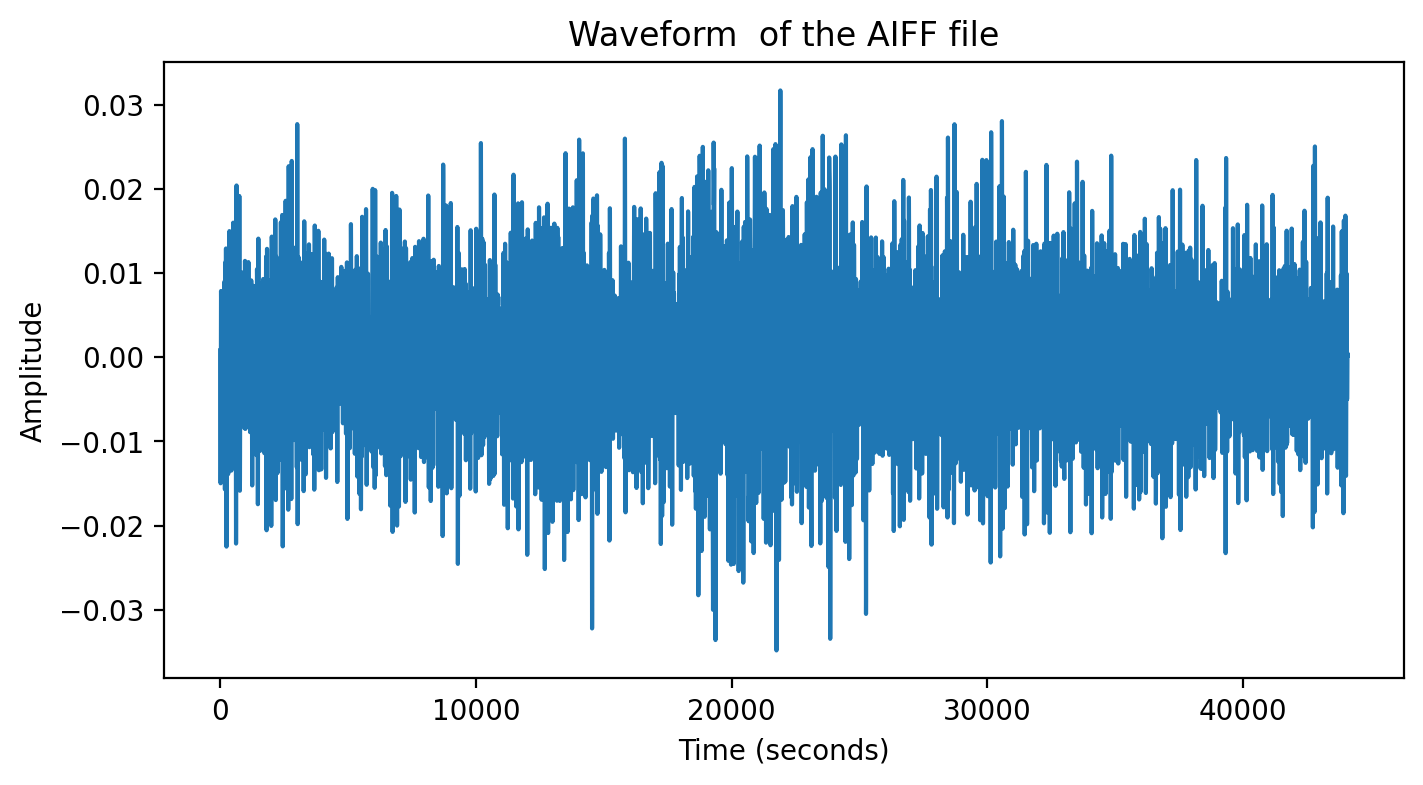

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(audio)
plt.title('Waveform  of the AIFF file')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

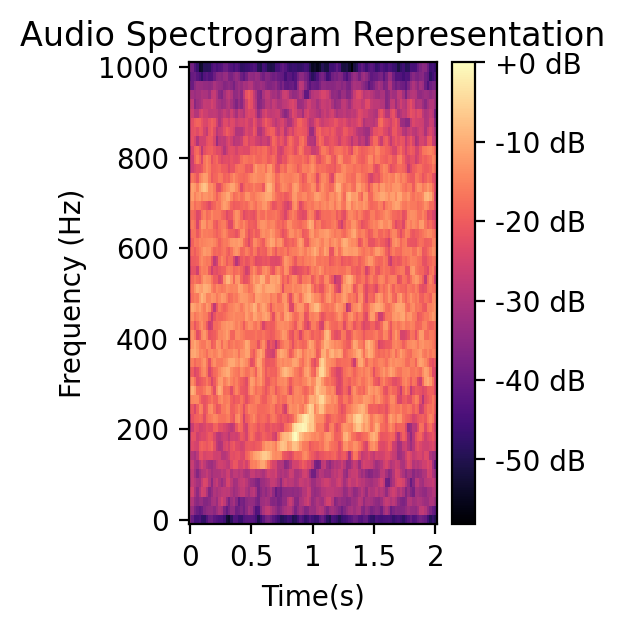

In [ ]:
samples, sr = sf.read(io.BytesIO(audio_file))

n_fft = 200 
hop_length = 40 
n_mels=50 
S = librosa.feature.melspectrogram(y=samples,
                                   sr=sr,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=n_mels,
                                   )
S_db = librosa.power_to_db(S, ref=np.max)
fig, ax = plt.subplots(figsize=(2,3))
librosa.display.specshow(S_db,
                         x_axis='time',
                         y_axis='linear',
                         sr=sr,
                         hop_length=hop_length,
                         )
plt.title("Audio Spectrogram Representation")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time(s)")
plt.ylabel("Frequency (Hz)")
plt.show()

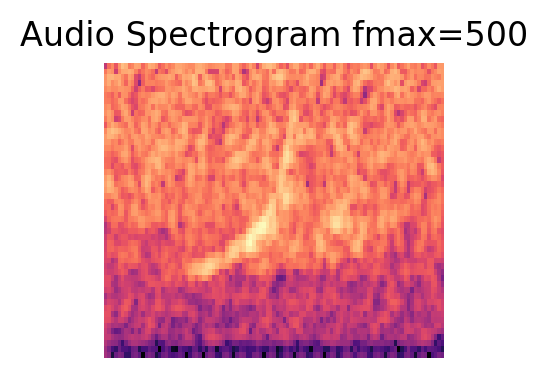

In [ ]:
samples, sr = sf.read(io.BytesIO(audio_file))

n_fft = 200
hop_length = 40
n_mels=50
S = librosa.feature.melspectrogram(y=samples,
                                   sr=sr,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=n_mels,
                                   fmax=500 
                                   )
S_db = librosa.power_to_db(S, ref=np.max)
fig, ax = plt.subplots(figsize=(2,2))
librosa.display.specshow(S_db,
                         x_axis='time',
                         y_axis='linear',
                         sr=sr,
                         hop_length=hop_length,
                         )
plt.title("Audio Spectrogram fmax=500")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
zipfiles = glob.glob('/content/drive/MyDrive/MLR/Audio/whale-detection-challenge/whale_data.zip')
for zippath in zipfiles:
    with zipfile.ZipFile(zippath, 'r') as zip_file:
        zip_file.extract('data/train.csv')
        labels = pd.read_csv(zip_file.open('data/train.csv'))

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='No Whale call',
           y=labels[labels['label']==0]['label'].value_counts(),
           x=['0'],
           text = labels[labels['label']==0]['label'].value_counts(),
           orientation='v',
           textposition='outside',),

    go.Bar(name='Whale call',
           y=labels[labels['label']==1]['label'].value_counts(),
           x=['1'],
           text = labels[labels['label']==1]['label'].value_counts(),
           orientation='v',
           textposition='outside',),
])

fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of Images',
                  xaxis_title='Class Name',)
iplot(fig)

## Image Augmentation

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])

    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')

    rotation_matrix = get_3x3_mat([c1,   s1,   zero,
                                   -s1,  c1,   zero,
                                   zero, zero, one])
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  s2,   zero,
                                zero, c2,   zero,
                                zero, zero, one])
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    shift_matrix = get_3x3_mat([one,  zero, height_shift,
                                zero, one,  width_shift,
                                zero, zero, one])

    return K.dot(K.dot(rotation_matrix, shear_matrix),
                 K.dot(zoom_matrix,     shift_matrix))

def transform(image, DIM=IMG_SIZES[0]):
    if DIM[0]!=DIM[1]:
        pad = (DIM[0]-DIM[1])//2
        image = tf.pad(image, [[0, 0], [pad, pad+1],[0, 0]])

    NEW_DIM = DIM[0]

    XDIM = NEW_DIM%2

    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32')

    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    x   = tf.repeat(tf.range(NEW_DIM//2, -NEW_DIM//2,-1), NEW_DIM)
    y   = tf.tile(tf.range(-NEW_DIM//2, NEW_DIM//2), [NEW_DIM])
    z   = tf.ones([NEW_DIM*NEW_DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )

    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -NEW_DIM//2+XDIM+1, NEW_DIM//2)

    idx3 = tf.stack([NEW_DIM//2-idx2[0,], NEW_DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))

    if DIM[0]!=DIM[1]:
        image = tf.reshape(d,[NEW_DIM, NEW_DIM,3])
        image = image[:, pad:DIM[1]+pad,:]
    image = tf.reshape(image, [*DIM, 3])

    return image

## Data Pipeline

In [ ]:
import numpy as np
import tensorflow as tf

LOCAL_TFRECORD_PATH = '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec'

files = np.sort(np.array(tf.io.gfile.glob(LOCAL_TFRECORD_PATH + '/train*.tfrec')))
num_train_files = len(files)
print('train_files:', num_train_files)

train_files: 10


In [ ]:

files

array(['/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train00-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train01-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train02-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train03-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train04-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train05-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train06-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train07-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train08-3000.tfrec',
       '/content/drive/MyDrive/MLR/Audio/whale-detection-tfrec/train09-3000.tfrec'],
      dtype='<U73')

In [ ]:


CLASSES = ['No whale call','Whale call']

def decode_image(image_data):
    image = tf.image.decode_png(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*[255, 255], 3]) 
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label 

def load_dataset(filenames, labeled=True, ordered=False):

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
def data_augment(img, label, dim=IMG_SIZES[0]):
    img = transform(img,DIM=dim) if TRANSFORM else img
    return img, label

def get_training_dataset():
    dataset = train_dataset.map(data_augment,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(1024*2, seed=SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = val_dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
NUM_IMAGES = count_data_items(files)

print('Dataset: {} total images'.format(NUM_IMAGES))

Dataset: 30000 total images


In [ ]:
train_size = int(0.8 * NUM_IMAGES)
val_size = int(0.20 * NUM_IMAGES)

full_dataset=load_dataset(files, labeled=True)
full_dataset = full_dataset.shuffle(1024*2, seed=SEED)
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

In [ ]:
ds_train = get_training_dataset()
ds_val=get_validation_dataset()

In [ ]:
print("Training:", ds_train,'\n')
print("Validation:", ds_val,'\n')

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 

Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 



In [ ]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: 
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def title_from_label_and_label(label, correct_label):
    if correct_label is None:
         return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_label(predictions[i][0], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
ds_iter = iter(ds_train.unbatch().batch(20))

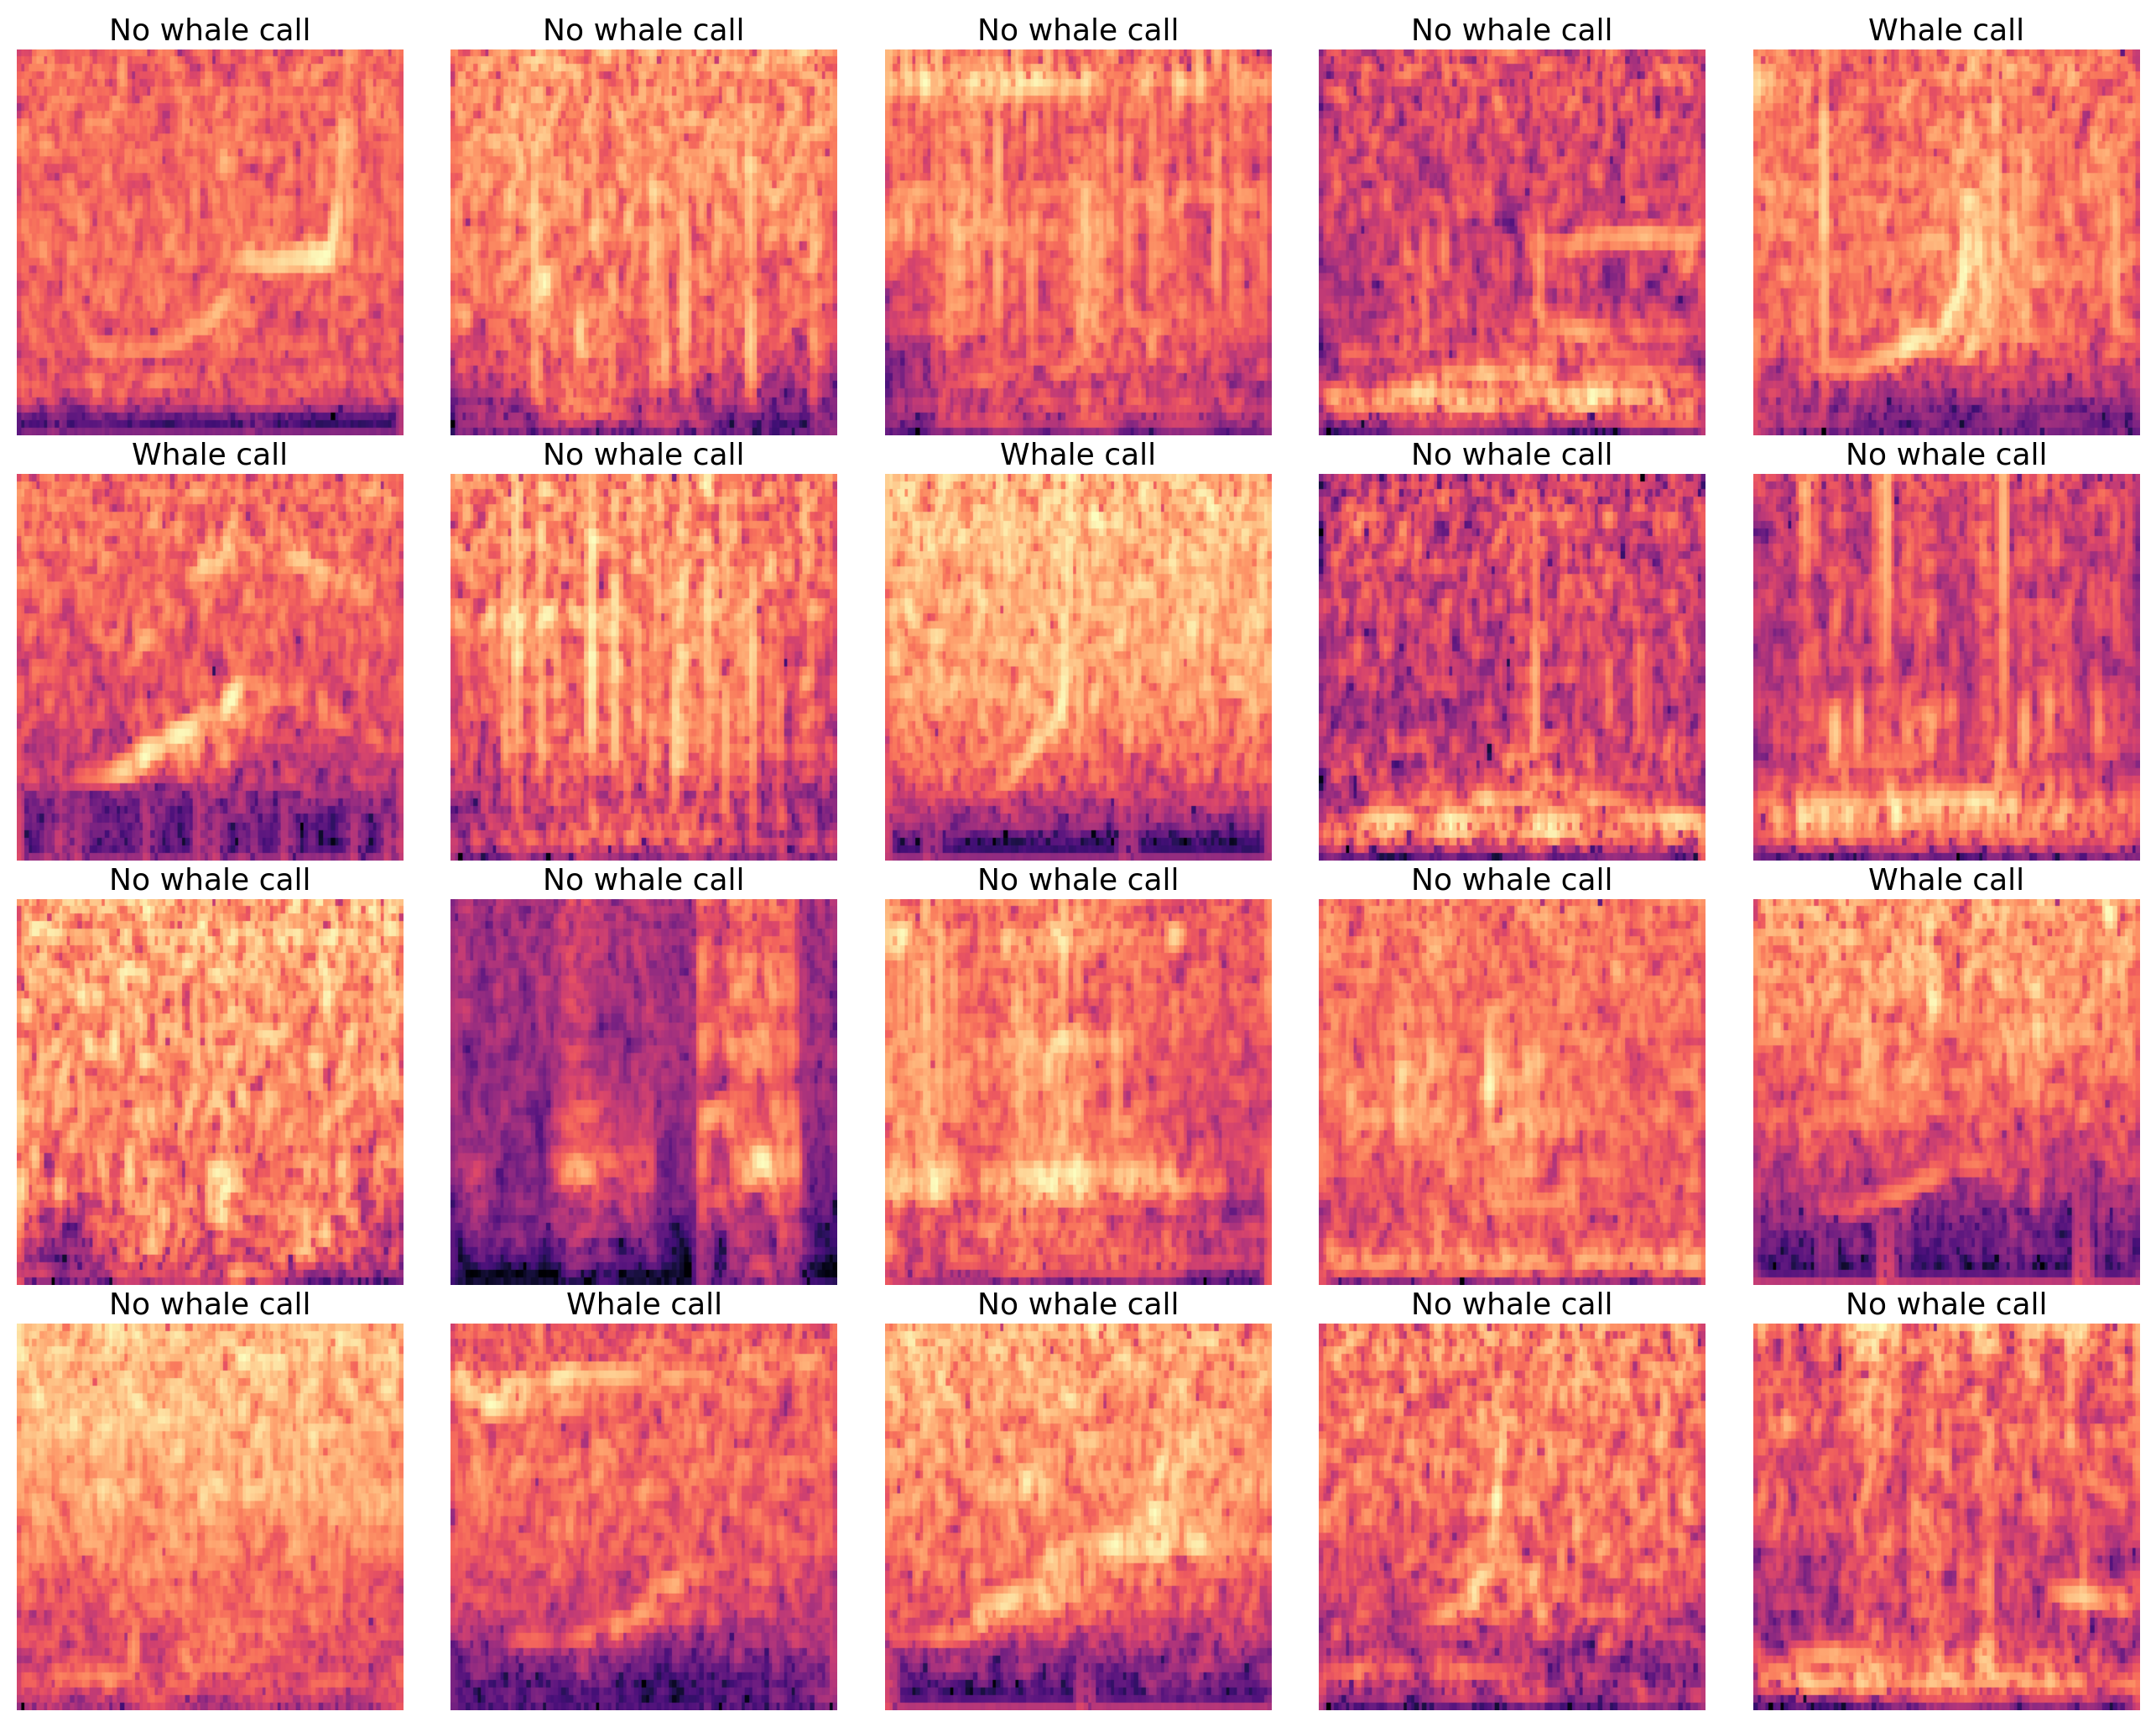

In [ ]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

## ConvNet Building

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def display_confusion_matrix(cmat):
    plt.figure(figsize=(4,4))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 10})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 10})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""

In [ ]:
def binary_focal_loss(gamma = 2., alpha = .25):
    def tf_binary_focal_loss_fixed(y_true, y_pred):
         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
         epsilon = K.epsilon()
         pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
         pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return tf_binary_focal_loss_fixed

In [ ]:
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.85):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)

In [ ]:
with strategy.scope():
    pretrained_model = efn.EfficientNetB2(
        weights='imagenet',
        include_top=False ,
        input_shape=[*[255,255], 3]
    )

    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),# use GAP to get pooling result form conv outputs
        tf.keras.layers.Dense(40, activation= 'relu'), # Dense layer with activation function for non-linearity
        tf.keras.layers.Dense(1, activation='sigmoid') # Output layer with 1 neuron and sigmoid activation function
    ])

In [ ]:
model.compile(
    optimizer='adam',
    loss=binary_focal_loss(),
    metrics=['binary_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functiona  (None, 8, 8, 1408)        7768562   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 40)                56360     
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7824963 (29.85 MB)
Trainable params: 56401 (220.32 KB)
Non-trainable params: 7768562 (29.63 MB)
_________________________________________________________________


In [ ]:

steps_per_epoch = 20
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS[0],
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback,early_stopping]
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/12
20/20 [==============================] - ETA: 0s - loss: 6.4048 - binary_accuracy: 0.7504 

## ConvNet Evalution

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)

display_training_curves(
    history.history['binary_accuracy'],
    history.history['val_binary_accuracy'],
    'accuracy',
    212,
)

In [ ]:
cmdataset = get_validation_dataset()
images_ds = cmdataset.map(lambda image, label:image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(val_size))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = (cm_probabilities > 0.5).astype(int)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    y_true=cm_correct_labels,
    y_pred=cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
display_confusion_matrix(cmat)

In [ ]:
#  F1, precision and recall score
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

print('F1 score of the model is:',round(score,3),'\n')
print('Precision of the model is:',round(precision,3),'\n')
print('Recall of the model is:',round(recall,3),'\n')

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

In [ ]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = (probabilities > 0.5).astype(int)
display_batch_of_images((images, labels), predictions)